## Statistics

With bar charts:
Degree distribution
In-degree and out-degree lists

Clustering coefficient
Betweeness centrality, closeness centrality

Insights:
Changes of trade between the years, especially in the Covid year
Potential differences in ranking of countries between degree and sum of trade value, prove that degree is a good measure
Does the network approximate a scale-free model?

## Load data

In [64]:
import collections
import warnings
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyvis import network as net
from scipy.stats import norm

%matplotlib inline

In [65]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [66]:
trade_file = pd.read_csv("eu-car-trade.csv")
data = trade_file
#data = trade_file[(trade_file['flow'] == 2)] # exports = 2, imports = 1
data["reporter"] = data["reporter"].astype(str)
data["partner"] = data["partner"].astype(str)
data.dtypes

DATAFLOW        object
LAST UPDATE     object
freq            object
reporter        object
partner         object
product          int64
flow             int64
indicators      object
TIME_PERIOD      int64
OBS_VALUE        int64
OBS_FLAG       float64
dtype: object

In [67]:
## Exploratory Data Analysis

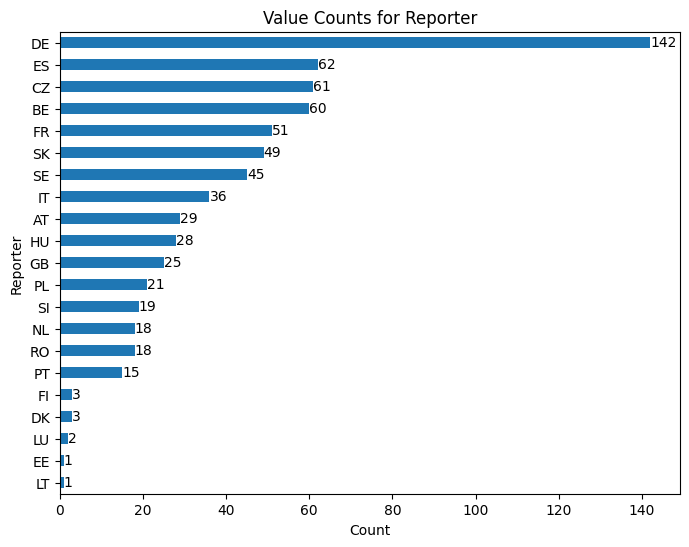

In [68]:
# filteredData = data[(data["OBS_VALUE"] > 200_000_000) & (data["TIME_PERIOD"] == 2018)] # Only consider export values over 100 million Euros

filtered_data = data[(data["OBS_VALUE"] > 200_000_000) & (data["flow"] == 2)] # (2) exports, (1) imports

values_out = filtered_data["reporter"].value_counts()
ax = values_out.plot.barh(figsize=(8,6))
ax.invert_yaxis()

for index, value in enumerate(values_out):
    ax.text(value, index, str(value), ha='left', va='center', fontsize=10)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Reporter')
plt.title('Value Counts for Reporter')

# Show the plot
plt.show()

# filtered_data.to_csv("filtered-data.csv", index = False)

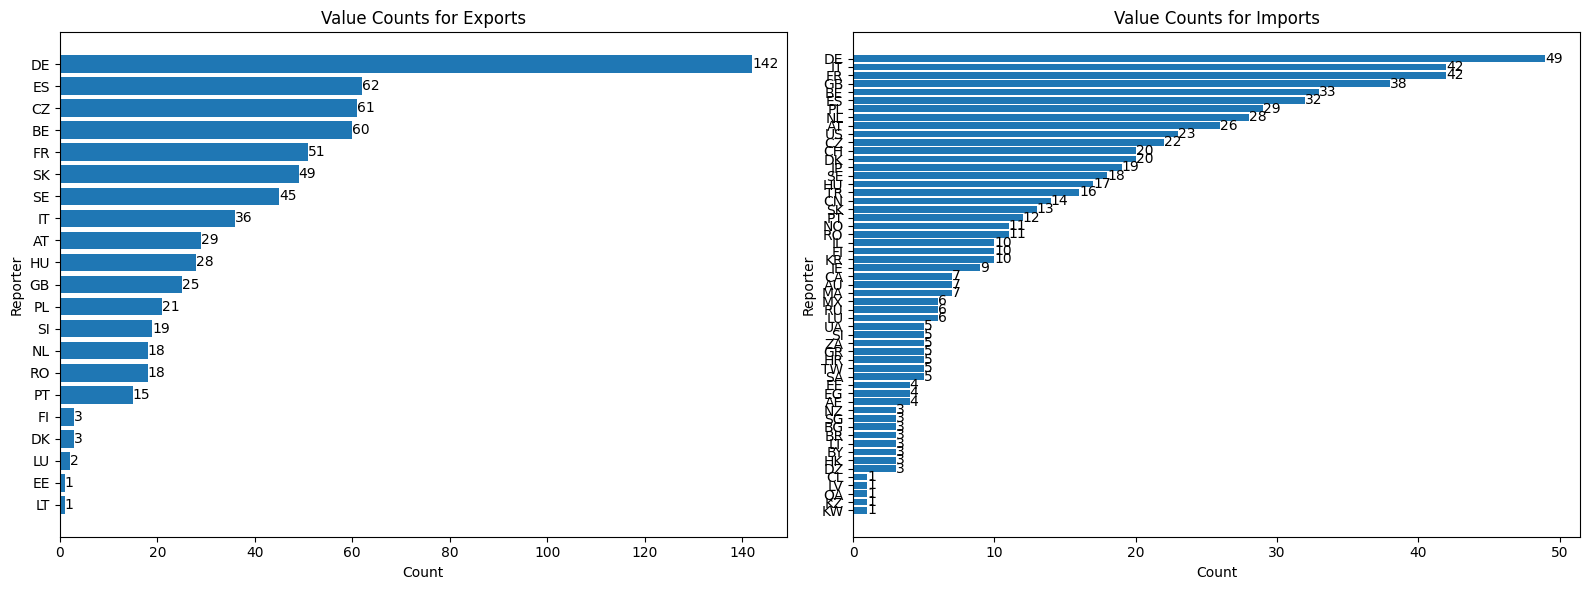

In [69]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the horizontal bar chart for exports
axs[0].barh(values_out.index, values_out)
axs[0].invert_yaxis()

# Add annotations to the bars in the first chart
for index, value in enumerate(values_out):
    axs[0].text(value, index, str(value), ha='left', va='center', fontsize=10)

axs[0].set_xlabel('Count')
axs[0].set_ylabel('Reporter')
axs[0].set_title('Value Counts for Exports')

# Plot the horizontal bar chart for imports
values_in = filtered_data["partner"].value_counts()
axs[1].barh(values_in.index, values_in)
axs[1].invert_yaxis()

# Add annotations to the bars in the second chart
for index, value in enumerate(values_in):
    axs[1].text(value, index, str(value), ha='left', va='center', fontsize=10)

axs[1].set_xlabel('Count')
axs[1].set_ylabel('Reporter')
axs[1].set_title('Value Counts for Imports')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

## Degree distribution and centrality

In [70]:
network = nx.from_pandas_edgelist(filtered_data, "reporter", "partner", "OBS_VALUE")

print("Number of nodes:", network.number_of_nodes(), "\nNumber of edges:", network.number_of_edges()) # (49, 182) (nodes,edges)

Number of nodes: 55 
Number of edges: 228


In [71]:
# graph = nx.k_core(network, 2) #remove all nodes with one edge 
# print("Number of nodes:", graph.number_of_nodes(), "\nNumber of edges:", graph.number_of_edges()) # (49, 182) (nodes,edges)

''' K-core:
Extract the k-core subgraph of a given graph. 
A k-core is a maximal subgraph in which all nodes have degree at least k. 
In other words, it is a subgraph where every node is connected to at least k other nodes within that subgraph.
'''

' K-core:\nExtract the k-core subgraph of a given graph. \nA k-core is a maximal subgraph in which all nodes have degree at least k. \nIn other words, it is a subgraph where every node is connected to at least k other nodes within that subgraph.\n'

In [72]:
network.edges()

EdgeView([('AT', 'BE'), ('AT', 'CN'), ('AT', 'CZ'), ('AT', 'DE'), ('AT', 'FR'), ('AT', 'GB'), ('AT', 'HU'), ('AT', 'IT'), ('AT', 'JP'), ('AT', 'KR'), ('AT', 'NL'), ('AT', 'RO'), ('AT', 'SK'), ('AT', 'US'), ('AT', 'ES'), ('AT', 'SI'), ('BE', 'CA'), ('BE', 'CH'), ('BE', 'CZ'), ('BE', 'DE'), ('BE', 'DK'), ('BE', 'ES'), ('BE', 'FI'), ('BE', 'FR'), ('BE', 'GB'), ('BE', 'HU'), ('BE', 'IE'), ('BE', 'IT'), ('BE', 'JP'), ('BE', 'LU'), ('BE', 'NL'), ('BE', 'NO'), ('BE', 'PL'), ('BE', 'PT'), ('BE', 'RO'), ('BE', 'SE'), ('BE', 'TR'), ('BE', 'TW'), ('BE', 'US'), ('BE', 'SK'), ('CN', 'DE'), ('CN', 'GB'), ('CN', 'IT'), ('CN', 'SE'), ('CN', 'SK'), ('CZ', 'AU'), ('CZ', 'CH'), ('CZ', 'DE'), ('CZ', 'DK'), ('CZ', 'EG'), ('CZ', 'ES'), ('CZ', 'FI'), ('CZ', 'FR'), ('CZ', 'GB'), ('CZ', 'HU'), ('CZ', 'IE'), ('CZ', 'IL'), ('CZ', 'IT'), ('CZ', 'MX'), ('CZ', 'NL'), ('CZ', 'NO'), ('CZ', 'PL'), ('CZ', 'RO'), ('CZ', 'SA'), ('CZ', 'SE'), ('CZ', 'SK'), ('CZ', 'TR'), ('CZ', 'SI'), ('DE', 'AE'), ('DE', 'AU'), ('DE', 'BG

In [73]:
# Calculate degree centrality

# Undirected edge count
degree_map = {} # create a map

degree_map = collections.defaultdict(int)
for node_a,node_b in network.edges(): #loop through edges
  degree_map[node_a] += 1
  degree_map[node_b] += 1
print("Undirected edge items:",list(degree_map.items())[:5])

# Directed edge count

indegree_map = {node: 0 for node in network.nodes()}
outdegree_map = {node: 0 for node in network.nodes()}
for source, target in network.edges(): # loop through edges
    outdegree_map[source] += 1  # out-degree from the reporter (source)
    indegree_map[target] += 1   # in-degree to the partner (target)
print("Indegree map items:", list(indegree_map.items())[:5])
print("Outdegree map items:", list(outdegree_map.items())[:5])

Undirected edge items: [('AT', 16), ('BE', 25), ('CN', 6), ('CZ', 25), ('DE', 53)]
Indegree map items: [('AT', 0), ('BE', 1), ('CN', 1), ('CZ', 2), ('DE', 4)]
Outdegree map items: [('AT', 16), ('BE', 24), ('CN', 5), ('CZ', 23), ('DE', 49)]


In [74]:
print(indegree_map)

{'AT': 0, 'BE': 1, 'CN': 1, 'CZ': 2, 'DE': 4, 'FR': 4, 'GB': 6, 'HU': 6, 'IT': 8, 'JP': 6, 'KR': 4, 'NL': 8, 'RO': 8, 'SK': 11, 'US': 8, 'CA': 4, 'CH': 7, 'DK': 6, 'ES': 15, 'FI': 3, 'IE': 4, 'LU': 3, 'NO': 5, 'PL': 10, 'PT': 6, 'SE': 17, 'TR': 7, 'TW': 3, 'AU': 5, 'EG': 2, 'IL': 3, 'MX': 3, 'SA': 3, 'AE': 2, 'BG': 1, 'BR': 1, 'BY': 2, 'CL': 1, 'EE': 2, 'GR': 3, 'HK': 1, 'HR': 1, 'KW': 1, 'KZ': 1, 'LT': 4, 'LV': 1, 'MA': 3, 'NZ': 2, 'QA': 1, 'RU': 3, 'SG': 1, 'SI': 8, 'UA': 2, 'ZA': 3, 'DZ': 1}


In [75]:
print(outdegree_map)

{'AT': 16, 'BE': 24, 'CN': 5, 'CZ': 23, 'DE': 49, 'FR': 20, 'GB': 24, 'HU': 6, 'IT': 12, 'JP': 2, 'KR': 2, 'NL': 5, 'RO': 3, 'SK': 9, 'US': 2, 'CA': 0, 'CH': 1, 'DK': 2, 'ES': 10, 'FI': 1, 'IE': 0, 'LU': 0, 'NO': 1, 'PL': 5, 'PT': 0, 'SE': 2, 'TR': 0, 'TW': 0, 'AU': 0, 'EG': 0, 'IL': 1, 'MX': 0, 'SA': 0, 'AE': 0, 'BG': 0, 'BR': 0, 'BY': 1, 'CL': 0, 'EE': 1, 'GR': 0, 'HK': 0, 'HR': 1, 'KW': 0, 'KZ': 0, 'LT': 0, 'LV': 0, 'MA': 0, 'NZ': 0, 'QA': 0, 'RU': 0, 'SG': 0, 'SI': 0, 'UA': 0, 'ZA': 0, 'DZ': 0}


### Degree Distribution of the Complete Network (2018, 2020, 2022)

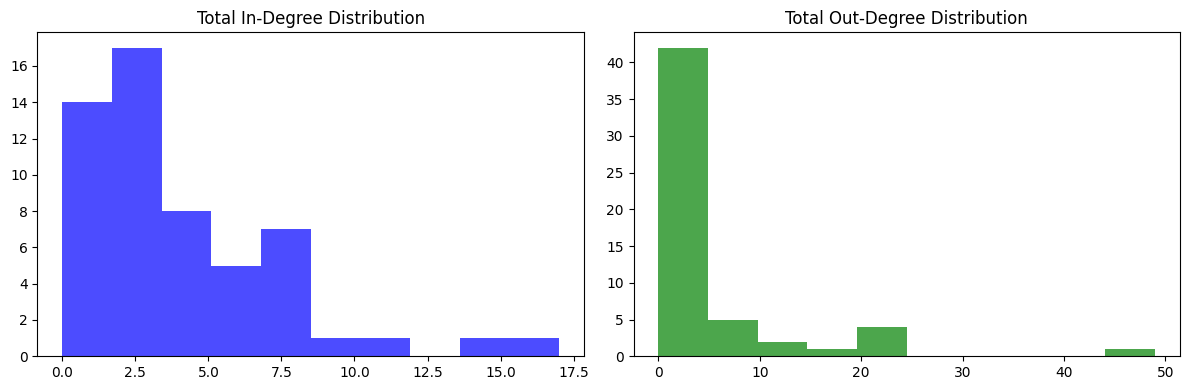

In [76]:
# Total In-Degree and Out-Degree Distribution by Year

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot the histogram for indegree_map on the left subplot (log1)
axs[0].hist(indegree_map.values(), color='blue', alpha=0.7)
axs[0].set_title('Total In-Degree Distribution')

# Plot the histogram for outdegree_map on the right subplot (log2)
axs[1].hist(outdegree_map.values(), color='green', alpha=0.7)
axs[1].set_title('Total Out-Degree Distribution')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

# _ = plt.hist(outdegree_map.values(), bins=2, log=True)

print()

# Degree Distribution by Year



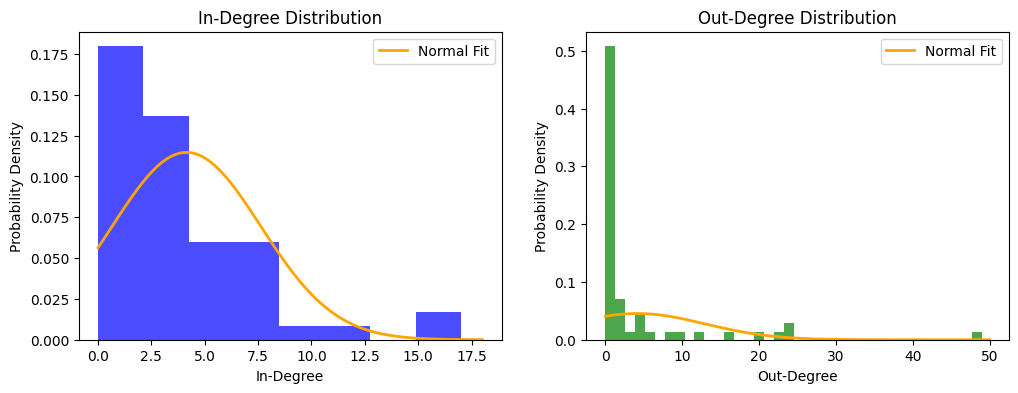

In [77]:
# Extract the in-degree and out-degree sequences
in_degree_sequence = list(indegree_map.values())
out_degree_sequence = list(outdegree_map.values())

# Plot histograms for in-degree and out-degree distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram for in-degree with distribution curve
axs[0].hist(in_degree_sequence, bins='auto', density=True, alpha=0.7, color='blue')
axs[0].set_title('In-Degree Distribution')
axs[0].set_xlabel('In-Degree')
axs[0].set_ylabel('Probability Density')

# Fit normal distribution to the in-degree data
mu, std = norm.fit(in_degree_sequence)
xmin, xmax = plt.xlim()
x = np.linspace(0, max(in_degree_sequence) + 1, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
axs[0].legend()

# Plot histogram for out-degree with distribution curve
axs[1].hist(out_degree_sequence, bins='auto', density=True, alpha=0.7, color='green')
axs[1].set_title('Out-Degree Distribution')
axs[1].set_xlabel('Out-Degree')
axs[1].set_ylabel('Probability Density')

# Fit normal distribution to the out-degree data
mu, std = norm.fit(out_degree_sequence)
xmin, xmax = plt.xlim()
x = np.linspace(0, max(out_degree_sequence) + 1, 100)
p = norm.pdf(x, mu, std)
axs[1].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
axs[1].legend()

### Degree Distribution Seperated by Year

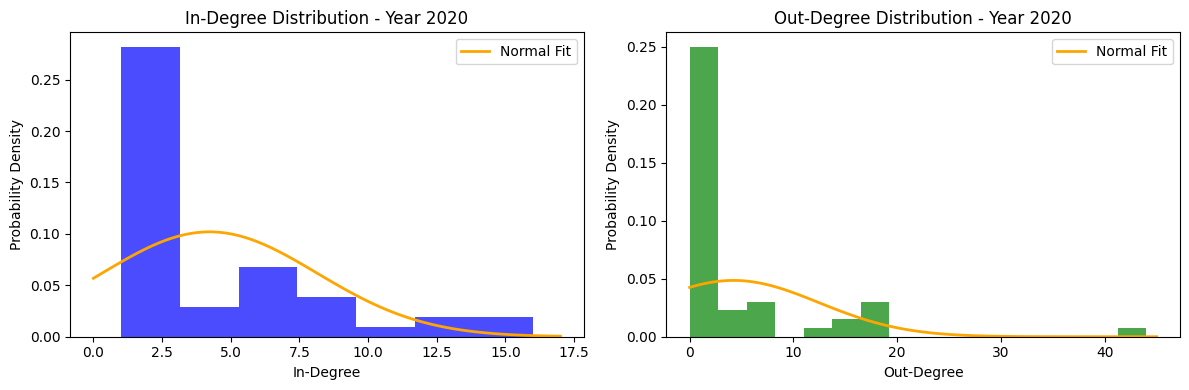

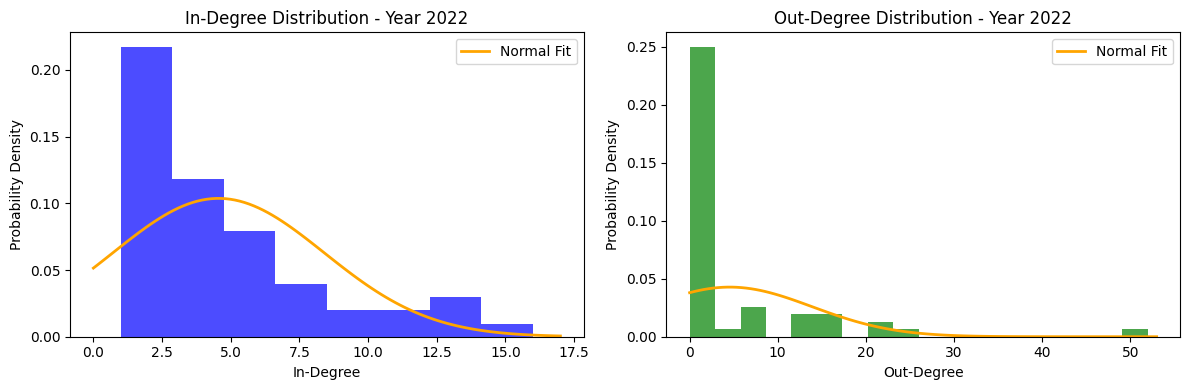

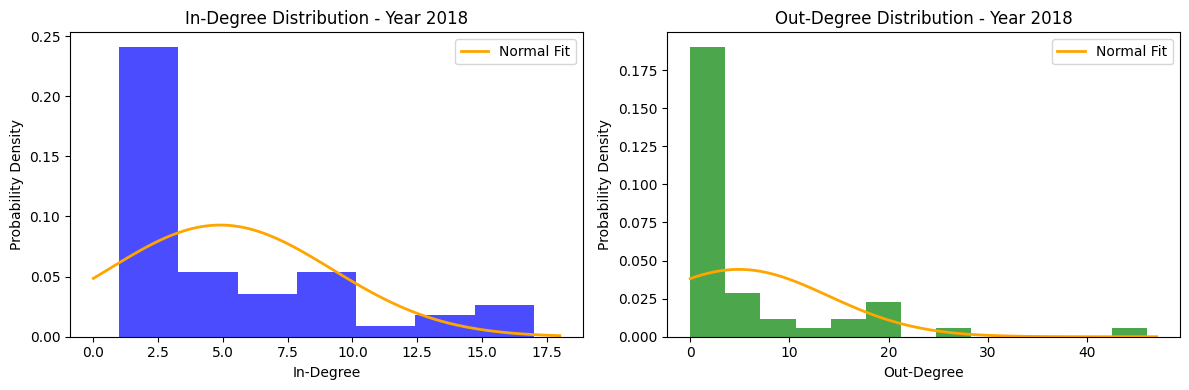

In [78]:
# List of unique years in the dataset
unique_years= filtered_data['TIME_PERIOD'].unique()

for year in unique_years:
    # Filter data for the current year
    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]

    # Create a directed graph from the filtered data
    graph_year = nx.from_pandas_edgelist(filtered_data_year, 'reporter', 'partner', 'OBS_VALUE', create_using=nx.DiGraph)

    # Reset indegree and outdegree maps for the current year
    in_degree_map_year = {node: 0 for node in graph_year.nodes()}
    out_degree_map_year = {node: 0 for node in graph_year.nodes()}

    # Calculate indegree and outdegree values
    for source, target in graph_year.edges(): # loop through edges
        if source in out_degree_map_year:
            out_degree_map_year[source] += 1  # out-degree from the reporter (source)
        else:
            out_degree_map_year[source] = 1   # initialize out-degree for the new source node

        if target in in_degree_map_year:
            in_degree_map_year[target] += 1   # in-degree to the partner (target)
        else:
            in_degree_map_year[target] = 1    # initialize in-degree for the new target node

    # Apply in-degree and out-degree sequence for the current year
    in_degree_sequence_year = list(in_degree_map_year.values())
    out_degree_sequence_year = list(out_degree_map_year.values())

    # Plot histograms for in-degree and out-degree distributions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    axs[0].hist(in_degree_sequence_year, bins='auto', density=True, alpha=0.7, color='blue') 
    axs[0].set_title(f'In-Degree Distribution - Year {year}')
    axs[0].set_xlabel('In-Degree')
    axs[0].set_ylabel('Probability Density')

    axs[1].hist(out_degree_sequence_year, bins='auto', density=True, alpha=0.7, color='green')
    axs[1].set_title(f'Out-Degree Distribution - Year {year}')
    axs[1].set_xlabel('Out-Degree')
    axs[1].set_ylabel('Probability Density')

    # Fit normal distribution to the in-degree data for the current year
    mu, std = norm.fit(in_degree_sequence_year)
    xmin, xmax = plt.xlim()
    x = np.linspace(0, max(in_degree_sequence_year) + 1, 100)
    p = norm.pdf(x, mu, std)
    axs[0].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
    axs[0].legend()

    # Fit normal distribution to the out-degree data for the current year
    mu, std = norm.fit(out_degree_sequence_year)
    xmin, xmax = plt.xlim()
    x = np.linspace(0, max(out_degree_sequence_year) + 1, 100)
    p = norm.pdf(x, mu, std)
    axs[1].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


*Reformulate:*

**The network has a right-skewed distrubution in all years.** This right-tailed distribution is characterized by a longer right tail compared to the left side. 

**Right-Skewed In-Degree Distribution:**

Nodes with higher in-degrees are less common, but there are a few nodes with significantly higher in-degrees than the majority.
In the context of car imports, this suggests that most countries have relatively low numbers of other countries exporting cars to them. However, there are a few countries that receive cars from a significantly larger number of partners.

**Right-Skewed Out-Degree Distribution:**

Nodes with higher out-degrees are less common, but there are a few nodes with significantly higher out-degrees than the majority.
In the context of car exports, this suggests that most countries export cars to a relatively low number of other countries. However, there are a few countries that export cars to a significantly larger number of partners.

These properties can have various interpretations:
<br>
**Hubs or Dominant Players:** The few nodes with high in-degrees (importers) or out-degrees (exporters) can be considered as "hubs" or dominant players in the network. These countries may have strong economic ties or a significant market share in the car trade.
<br>
**Trade Imbalances:** In the case of a skewed distribution, there may be a significant imbalance in the car trade. Some countries may be major importers, receiving cars from various sources, while others may be major exporters, sending cars to numerous destinations.
<br>
**Specialization:** Countries with high out-degrees might be specializing in car manufacturing and exporting, while those with high in-degrees might be more focused on importing cars. The skewed distribution could reflect specialization in certain industries or economic activities.
<br>
**Network Structure:** The right-skewed distribution suggests that the network has a hierarchical or scale-free structure, where a small number of nodes (countries) play a central role, and the majority have lower connectivity.

**Subgraph Germany - Degrees by Year**

In [79]:
# node_sizes = [d[i] for i in network.nodes()]

# Create a directed graph from the filtered data

data_DE = filtered_data[(filtered_data['reporter'] == 'DE')]
# data_DE in graph_DE

# Create a directed graph from the filtered data
graph_DE = nx.from_pandas_edgelist(data_DE, 'reporter', 'partner', ['OBS_VALUE'], create_using=nx.DiGraph)

# Check if all nodes in DE exist in the network G
all_nodes_exist = all(graph_DE.has_node(node) for node in data_DE['reporter'])
print(all_nodes_exist)

True


In [80]:
# Finding node neighbors for Germany

all_neighbors = {}
for node in data_DE['reporter']:
    neighbors = list(graph_DE.neighbors(node))
    all_neighbors[node] = neighbors
print(all_neighbors)

# Test for an edge between neighbors
member_id = 'AU'
edges_exist = all(graph_DE.has_edge(node, member_id) for node in data_DE['reporter'])
# print(edges_exist)

# Weights and Edges

# Store weights in a list
edge_weights = [graph_DE.edges[edge]["OBS_VALUE"] for edge in graph_DE.edges]

# Check the number of graph edges matches with the number of edge weights
print("Number of edges in graph:", len(graph_DE.edges))
print("Length of edge_weights:", len(edge_weights))

# Remove self-loops
graph_DE.remove_edges_from(nx.selfloop_edges(graph_DE))

{'DE': ['AE', 'AT', 'AU', 'BE', 'BG', 'BR', 'BY', 'CA', 'CH', 'CL', 'CN', 'CZ', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HK', 'HR', 'HU', 'IE', 'IL', 'IT', 'JP', 'KR', 'KW', 'KZ', 'LT', 'LU', 'LV', 'MA', 'MX', 'NL', 'NO', 'NZ', 'PL', 'PT', 'QA', 'RO', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'TR', 'TW', 'UA', 'US', 'ZA']}
Number of edges in graph: 53
Length of edge_weights: 53


### Subgraph DE

Still working on this

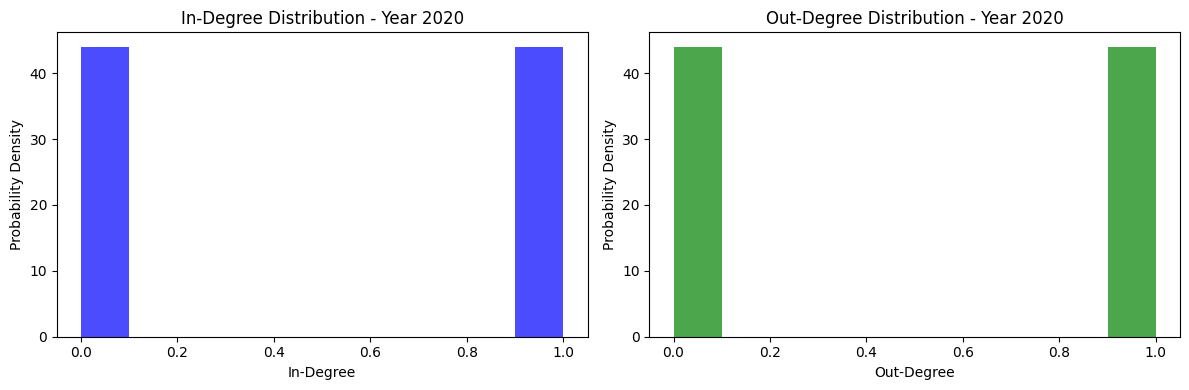

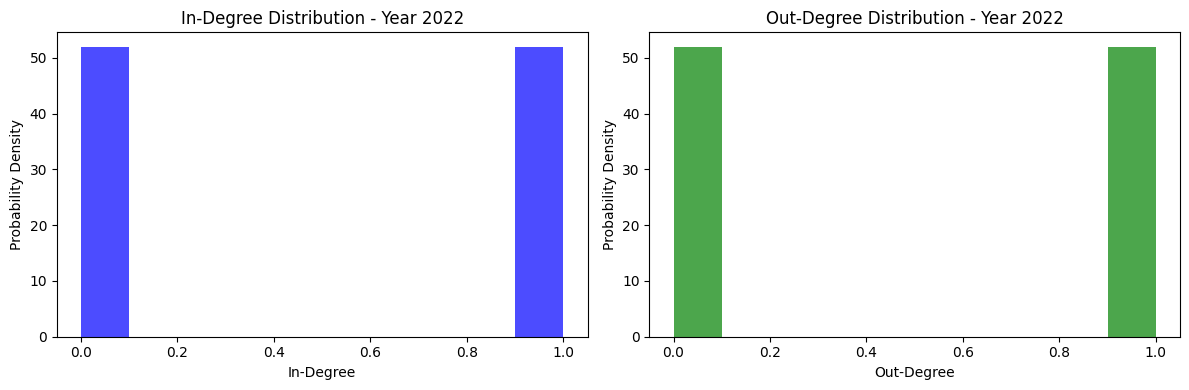

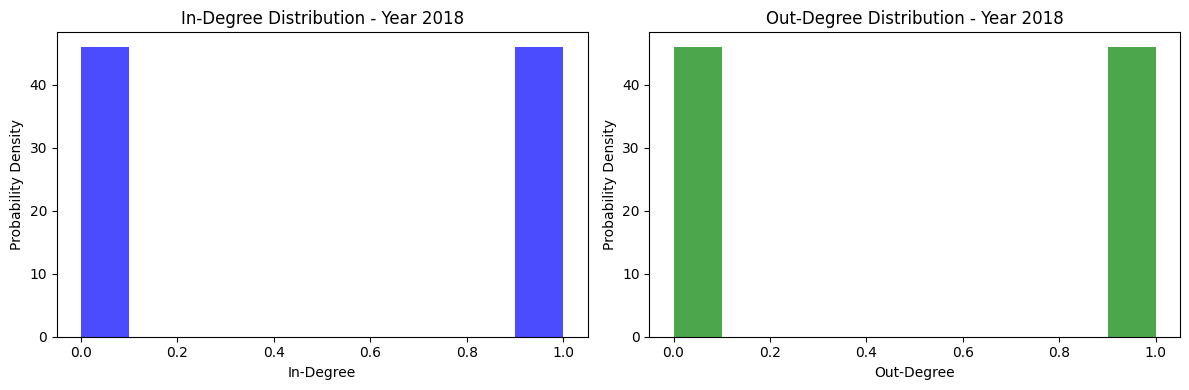

In [86]:
# List of unique years in the dataset
unique_years_DE = filtered_data['TIME_PERIOD'].unique()

for year in unique_years_DE:
    # Filter data for the current year
    filtered_data_year = data_DE[(data_DE['TIME_PERIOD'] == year)]

    # Create a directed graph from the filtered data
    graph_year = nx.from_pandas_edgelist(filtered_data_year, 'partner', 'OBS_VALUE', create_using=nx.DiGraph)

    # Reset indegree and outdegree maps for the current year
    indegree_map_year = {node: 0 for node in graph_year.nodes()}
    outdegree_map_year = {node: 0 for node in graph_year.nodes()}

    # Calculate indegree and outdegree values
    for source, target in graph_year.edges(): # loop through edges
        outdegree_map_year[source] += 1  # out-degree from the reporter (source)
        indegree_map_year[target] += 1   # in-degree to the partner (target)

    # Extract the in-degree and out-degree sequences after calculation
    in_degree_sequence_year = list(indegree_map_year.values())
    out_degree_sequence_year = list(outdegree_map_year.values())

    # Plot histograms for in-degree and out-degree distributions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    axs[0].hist(in_degree_sequence_year, color='blue', alpha=0.7)
    axs[0].set_title(f'In-Degree Distribution - Year {year}')
    axs[0].set_xlabel('In-Degree')
    axs[0].set_ylabel('Probability Density')
    
    axs[1].hist(out_degree_sequence_year, color='green', alpha=0.7)
    axs[1].set_title(f'Out-Degree Distribution - Year {year}')
    axs[1].set_xlabel('Out-Degree')
    axs[1].set_ylabel('Probability Density')

    # Extract the in-degree and out-degree sequences
    in_degree_sequence_year = list(indegree_map_year.values())
    out_degree_sequence_year = list(outdegree_map_year.values())

    # # Fit normal distribution to the in-degree data
    # mu, std = norm.fit(in_degree_sequence_year)
    # xmin, xmax = plt.xlim()
    # x = np.linspace(0, max(in_degree_sequence_year) + 1, 100)
    # p = norm.pdf(x, mu, std)
    # axs[0].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
    # axs[0].legend()

    # # Fit normal distribution to the out-degree data
    # mu, std = norm.fit(out_degree_sequence_year)
    # xmin, xmax = plt.xlim()
    # x = np.linspace(0, max(out_degree_sequence_year) + 1, 100)
    # p = norm.pdf(x, mu, std)
    # axs[1].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
    # axs[1].legend()
    
    plt.tight_layout()
    plt.show()

### Local Clustering Coefficient

### Betweenness Centrality



### Closeness Centrality

### Visualisation Ideas

In [82]:
# scikit-network

# ML -> scikit-learn and Karate Club(needs scikit,TensorFLow,PyTorch,etc.)

In [83]:
## Ego graph for cluster analysis

# draw_ego_graph(df, 'GE')
# draw_ego_graph(df, 'GE', center=False, k=1) # drop the center node for isolated node groups, k=1 shows closest neighboring groups
# -> Germany ego graph with dropped center and dropped isolates

### Graphing (Máté)

In [84]:
# Set node size to degree
d = dict(network.degree)
# Updating dict
# d.update((x, y) for x, y in d.items())
nx.set_node_attributes(network,d,'size') 
# each node in graph will now have a 'size' attribute and it's value will be the degree of the corresponding node